# Facies classification using Machine Learning #
## LA Team Submission 2 ## 
### _[Lukas Mosser](https://at.linkedin.com/in/lukas-mosser-9948b32b/en), [Alfredo De la Fuente](https://pe.linkedin.com/in/alfredodelafuenteb)_ ####

In this python notebook we explore a facies classification model using a Deep Neural Network arquitecture that takes into account spatial dependencies to outperform the prediction model proposed in the [prediction facies from wel logs challenge](https://github.com/seg/2016-ml-contest). 

## Problem Modeling
----

The dataset we will use comes from a class excercise from The University of Kansas on [Neural Networks and Fuzzy Systems](http://www.people.ku.edu/~gbohling/EECS833/).  This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see [Bohling and Dubois (2003)](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf) and [Dubois et al. (2007)](http://dx.doi.org/10.1016/j.cageo.2006.08.011). 

The dataset we will use is log data from nine wells that have been labeled with a facies type based on oberservation of core.  We will use this log data to train a classifier to predict facies types. 

This data is from the Council Grove gas reservoir in Southwest Kansas.  The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas.  This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector.  Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate. 

The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8


## Data Preprocessing
---

Let's import all the libraries that will be particularly needed for the analysis.

In [1]:
%%sh
pip install pandas
pip install scikit-learn
pip install keras

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from __future__ import print_function
import numpy as np
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from classification_utilities import display_cm, display_adj_cm
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import preprocessing

Using TensorFlow backend.


We load the training and testing data to preprocess it for further analysis.

In [21]:
filename = 'train_test_data.csv'
training_data = pd.read_csv(filename)
training_data.head(10)

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915
5,3,A1 SH,SHRIMPLIN,2795.5,73.97,0.636,14.0,13.385,3.6,1,0.894
6,3,A1 SH,SHRIMPLIN,2796.0,73.72,0.630,15.6,13.930,3.7,1,0.872
7,3,A1 SH,SHRIMPLIN,2796.5,75.65,0.625,16.5,13.920,3.5,1,0.830
8,3,A1 SH,SHRIMPLIN,2797.0,73.79,0.624,16.2,13.980,3.4,1,0.809
9,3,A1 SH,SHRIMPLIN,2797.5,76.89,0.615,16.9,14.220,3.5,1,0.787


We fill the missing data values in the PE field with zero and proceed to normalize the data that will be fed into our model.

In [22]:
# Set 'Well Name' and 'Formation' fields as categories
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')

# Fill missing values and normalize for 'PE' field
training_data['PE'] = training_data['PE'].fillna(value=0)
mean_pe = training_data['PE'].mean()
std_pe = training_data['PE'].std()
training_data['PE'] = (training_data['PE']-mean_pe)/std_pe

# Normalize the rest of fields (GR, ILD_log10, DelthaPHI, PHIND,NM_M,RELPOS)
correct_facies_labels = training_data['Facies'].values
feature_vectors = training_data.drop(['Formation', 'Depth'], axis=1)
well_labels = training_data[['Well Name', 'Facies']].values
data_vectors = feature_vectors.drop(['Well Name', 'Facies'], axis=1).values

scaler = preprocessing.StandardScaler().fit(data_vectors)
scaled_features = scaler.transform(data_vectors)
data_out = np.hstack([well_labels, scaled_features])

In order to start training stage, it is required to format the data by considering a sliding window over the depth component in order to classify a given set of features at some specific depth for each well in the training set.

In [23]:
def preprocess(data_out):
    data = data_out
    well_data = {}
    well_names = list(set(data[:, 0]))
    for name in well_names:
        well_data[name] = [[], []]

    for row in data:
        well_data[row[0]][1].append(row[1])
        well_data[row[0]][0].append(list(row[2::]))

    # Sliding window
    positive_lag = 5
    negative_lag = 5

    chunks = []
    chunks_test = []
    chunk_length = positive_lag+negative_lag+1 
    chunks_facies = []
    for name in well_names:
        if name not in ['STUART', 'CRAWFORD']:
            test_well_data = well_data[name]
            log_values = np.array(test_well_data[0])
            log_values_padded = np.lib.pad(log_values, (negative_lag,positive_lag), 'edge')[:, negative_lag:-positive_lag]
            facies_values =  np.array(test_well_data[1])
            for i in range(log_values.shape[0]):
                chunks.append(log_values_padded[i:i+chunk_length, :])
                chunks_facies.append(facies_values[i])
        else:
            test_well_data = well_data[name]
            log_values = np.array(test_well_data[0])
            log_values_padded = np.lib.pad(log_values, (negative_lag,positive_lag), 'edge')[:, negative_lag:-positive_lag]
            facies_values =  np.array(test_well_data[1])
            for i in range(log_values.shape[0]):
                chunks_test.append(log_values_padded[i:i+chunk_length, :])
    
    chunks_facies = np.array(chunks_facies, dtype=np.int32)-1
    X_ = np.array(chunks)
    X = np.zeros((len(X_),len(X_[0][0]) * len(X_[0])))
    for i in range(len(X_)):
        X[i,:] = X_[i].flatten()
        
    X_test = np.array(chunks_test)
    X_test_out = np.zeros((len(X_test),len(X_test[0][0]) * len(X_test[0])))
    for i in range(len(X_test)):
        X_test_out[i,:] = X_test[i].flatten()
    y = np_utils.to_categorical(chunks_facies)
    return X, y, X_test_out

## Data Analysis
---
Our model will be composed by a Deep Neural Network of an input layer, two hidden layers and an output layer.
As input we will consider a set of features extracted by padding a depth interval segment, that way we take into account spatial dependencies.

In [29]:
np.random.seed(1337) # For reproducibility
X_train, y_train, X_test = preprocess(data_out)

In [30]:
# Set parameters
input_dim = 77
hidden_dim_1 = 128
hidden_dim_2 = 32
output_dim = 9 
batch_size = 32
nb_epoch = 10

In [31]:
def proposed_model():
    # Define the model
    model = Sequential()
    model.add(Dense(128, input_dim=77, init='normal', activation='relu'))
    model.add(Dense(32, input_dim=128, init='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(9, init='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In order to evaluate our classification model accurary we will use the our following defined metrics, based on the confusion matrix once the classification is performed. The first metric only considers misclassification error and the second one takes into account the fact that facies could be misclassified if they belong to a same group with similar geological characteristics.

In [32]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS','WS', 'D','PS', 'BS']

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

Once the set of parameters are fixed, the training stage of our model begins. We perform a Cross Validation routine to evaluate the performance of the model.

In [33]:
estimator = KerasClassifier(build_fn=proposed_model, nb_epoch=10, batch_size=50, verbose=0)
# Cross Validation
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print(' Cross Validation Results')
print( results )

 Cross Validation Results
[ 0.59759037  0.62409639  0.62530121  0.60481929  0.61761158]


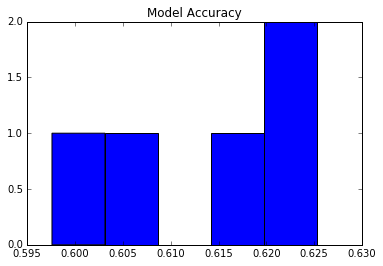

Cross Validation Average Accuracy 0.614
Cross Validation Standard Deviation 0.011


In [34]:
plt.hist(results, bins= 5) 
plt.title("Model Accuracy")
plt.show()
print ( "Cross Validation Average Accuracy %.3f" %  results.mean() )
print ( "Cross Validation Standard Deviation %.3f" %  results.std() )

In [35]:
# Load the model
model = proposed_model()
#Train model
model.fit(X_train, y_train, nb_epoch=10, verbose=2, shuffle = True)

Epoch 1/10
0s - loss: 1.5555 - acc: 0.4218
Epoch 2/10
0s - loss: 1.1576 - acc: 0.5358
Epoch 3/10
0s - loss: 1.0710 - acc: 0.5724
Epoch 4/10
0s - loss: 1.0215 - acc: 0.5929
Epoch 5/10
0s - loss: 0.9765 - acc: 0.6026
Epoch 6/10
0s - loss: 0.9426 - acc: 0.6204
Epoch 7/10
0s - loss: 0.9102 - acc: 0.6317
Epoch 8/10
0s - loss: 0.8913 - acc: 0.6327
Epoch 9/10
0s - loss: 0.8705 - acc: 0.6457
Epoch 10/10
0s - loss: 0.8456 - acc: 0.6455


In [36]:
# Predict Values on Training set
y_predicted = model.predict( X_train , batch_size=32, verbose=0)

# Print Report

# Format output [0 - 8 ]
y_ = np.zeros((len(y_train),1))
for i in range(len(y_train)):
    y_[i] = np.argmax(y_train[i])

y_predicted_ = np.zeros((len(y_predicted), 1))
for i in range(len(y_predicted)):
    y_predicted_[i] = np.argmax( y_predicted[i])
    
# Confusion Matrix
conf = confusion_matrix(y_, y_predicted_)

# Print Results
print ("\nModel Report")
print ("-Accuracy: %.6f" % ( accuracy(conf) ))
print ("-Adjacent Accuracy: %.6f" % ( accuracy_adjacent(conf, adjacent_facies) ))
print ("\nConfusion Matrix")
display_cm(conf, facies_labels, display_metrics=True, hide_zeros=True)


Model Report
-Accuracy: 0.687877
-Adjacent Accuracy: 0.941673

Confusion Matrix
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS   152   113     3                                       268
     CSiS    21   794   122                 2           1         940
     FSiS     1   272   501                 2           3     1   780
     SiSh           2     3   216     1    41     3     5         271
       MS           6     6    32    33   145     8    66         296
       WS                 1    46    12   355    10   157     1   582
        D                 1     3          10   115    12         141
       PS                 6     4     6    85    14   568     3   686
       BS                       5          16     3    41   120   185

Precision  0.87  0.67  0.78  0.71  0.63  0.54  0.75  0.67  0.96  0.70
   Recall  0.57  0.84  0.64  0.80  0.11  0.61  0.82  0.83  0.65  0.69
       F1  0.69  0.75  0.70  0.75  0.19  0.57  0.78  0.74  0.77  0.6

## Prediction
---
We obtain the predictions for test data.

In [63]:
y_test = model.predict( X_test , batch_size=32, verbose=0)
final_predictions = np.zeros((len(y_test),1))
for i in range(len(y_test)):
    final_predictions[i] = np.argmax(y_test[i]) + 1 

In [73]:
last_submission = pd.read_csv('Prediction.csv')
ls = last_submission['Facies'].as_matrix()

In [74]:
conf = confusion_matrix(ls, final_predictions)

# Print Results
print ("\nModel Report")
print ("-Accuracy: %.6f" % ( accuracy(conf) ))
print ("-Adjacent Accuracy: %.6f" % ( accuracy_adjacent(conf, adjacent_facies) ))
print ("\nConfusion Matrix")
display_cm(conf, facies_labels, display_metrics=True, hide_zeros=True)


Model Report
-Accuracy: 0.798795
-Adjacent Accuracy: 0.938554

Confusion Matrix
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS                                         8     7          15
     CSiS         185    27                             1         213
     FSiS          10    45                                        55
     SiSh                      49          10           1          60
       MS                       1                       1           2
       WS                       9     4   129     4    31         177
        D                       7                51     1          59
       PS                       2     5    23     5   203     9   247
       BS                                               1     1     2

Precision  0.00  0.95  0.62  0.72  0.00  0.80  0.75  0.83  0.10  0.81
   Recall  0.00  0.87  0.82  0.82  0.00  0.73  0.86  0.82  0.50  0.80
       F1  0.00  0.91  0.71  0.77  0.00  0.76  0.80  0.82  0.17  0.8

classification_utilities.py:13: RuntimeWarning: invalid value encountered in divide
  precision = np.diagonal(cm)/cm.sum(axis=0).astype('float')
classification_utilities.py:15: RuntimeWarning: invalid value encountered in divide
  F1 = 2 * (precision * recall) / (precision + recall)


In [77]:
# Store results
test_data = pd.read_csv('../validation_data_nofacies.csv')
test_data['Facies'] = final_predictions
test_data.to_csv('Prediction2.csv')